In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Notebook içine gömülen görsellerin "ağırlığını" düşürür
mpl.rcParams["figure.dpi"] = 80
mpl.rcParams["savefig.dpi"] = 80
mpl.rcParams["figure.figsize"] = (10, 6)

# Çok büyük figürleri otomatik sınırlamak için (opsiyonel)
MAX_FIGSIZE = (12, 12)


**0.1 Kütüphaneler**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray


**0.2 Veri Yolu**

In [18]:
image_paths = "/content/drive/MyDrive/ISIC_data/"


In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1 - RGB → Grayscale Dönüşümü**

**RGB → Gray öncesi kıl bastırma fonksiyonu**

In [5]:
import cv2
import numpy as np

def hair_removal_rgb(img_rgb):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT, kernel)

    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    inpainted = cv2.inpaint(img_gray, mask, 1, cv2.INPAINT_TELEA)

    return inpainted


**1) RGB → Grayscale + Artefakt Bastırma (9 örnek)**

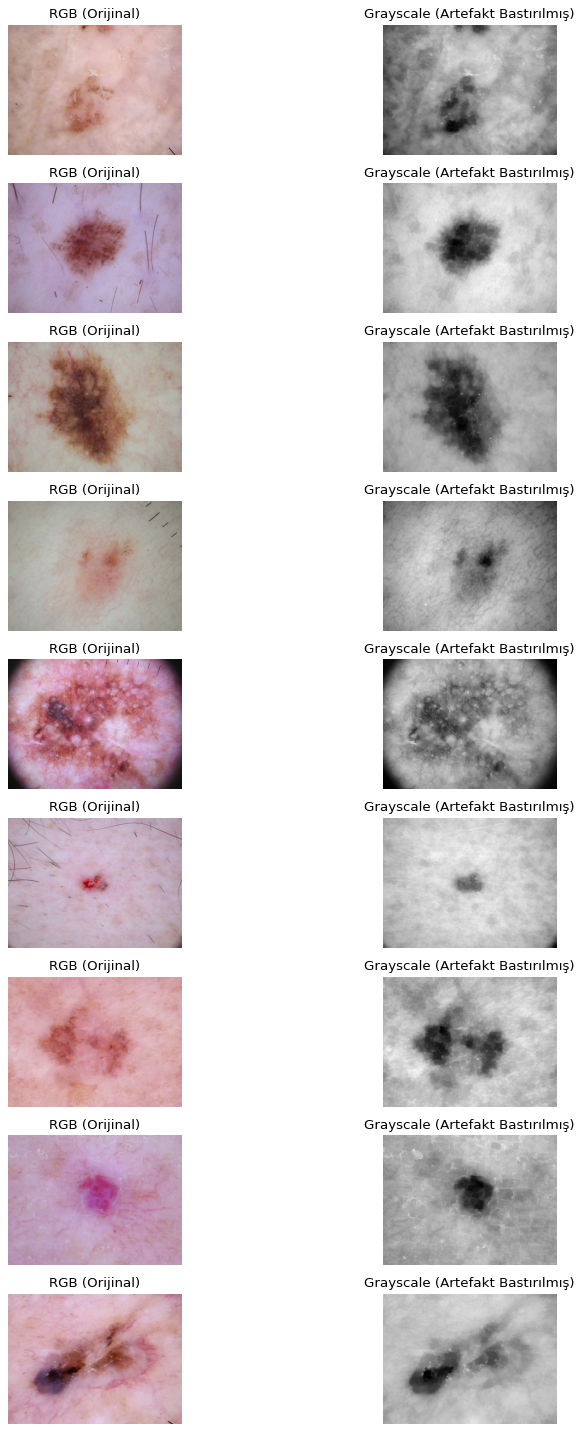

In [23]:
import matplotlib.pyplot as plt
from skimage.io import imread
import random
import os

image_dir_path_source = DATA_PATH

image_paths = []
if os.path.isdir(image_dir_path_source):
    for root, _, files in os.walk(image_dir_path_source):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
else:
    print(f"Hata: '{image_dir_path_source}' geçerli bir dizin yolu değil.")

# Eğer hiç resim bulunamazsa hata mesajı ver
if not image_paths:
    print(f"Hata: '{image_dir_path_source}' dizininde hiç resim dosyası bulunamadı.")
else:

    num_samples = min(9, len(image_paths))
    sample_paths = random.sample(image_paths, num_samples)

    plt.figure(figsize=(12, 18))

    for i, p in enumerate(sample_paths):
        rgb = imread(p)
        gray_clean = hair_removal_rgb(rgb)

        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(rgb)
        plt.title("RGB (Orijinal)")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(gray_clean, cmap="gray")
        plt.title("Grayscale (Artefakt Bastırılmış)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


**2 - Pre-Processing**

**2.1 Crop**


**Crop fonksiyonu**

In [24]:
def center_crop(img, crop_ratio=0.1):
    h, w = img.shape[:2]
    dh = int(h * crop_ratio)
    dw = int(w * crop_ratio)
    return img[dh:h-dh, dw:w-dw]


**2.1 Crop – 9 örnek görselleştirme**

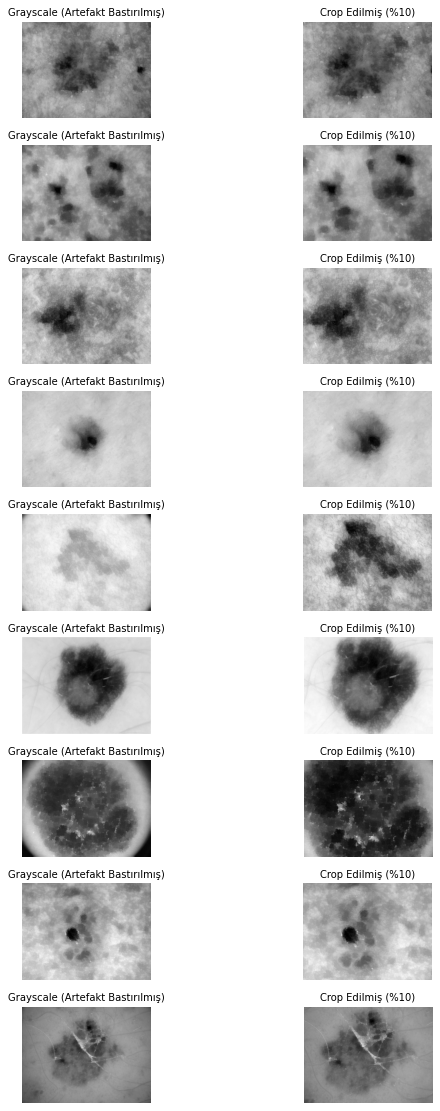

Kaydedildi: figures/crop_grayscale_artifact_9samples.png


In [70]:
import os
import random
import matplotlib.pyplot as plt
from skimage.io import imread
from IPython.display import Image, display

os.makedirs("figures", exist_ok=True)

# Güvenli örnekleme
k = min(9, len(image_paths))
sample_paths = random.sample(image_paths, k)

plt.figure(figsize=(9, 14))

for i, p in enumerate(sample_paths):
    rgb = imread(p)

    # 1) Artifact (kıl) bastırma + grayscale
    gray_artifact = hair_removal_rgb(rgb)

    # 2) Crop (sabit %10, merkezden)
    gray_crop = center_crop(gray_artifact, crop_ratio=0.1)

    # --- Orijinal (artifact bastırılmış grayscale) ---
    plt.subplot(9, 2, 2*i + 1)
    plt.imshow(gray_artifact, cmap="gray")
    plt.title("Grayscale (Artefakt Bastırılmış)", fontsize=9)
    plt.axis("off")

    # --- Crop edilmiş ---
    plt.subplot(9, 2, 2*i + 2)
    plt.imshow(gray_crop, cmap="gray")
    plt.title("Crop Edilmiş (%10)", fontsize=9)
    plt.axis("off")

plt.tight_layout()

out_path = "figures/crop_grayscale_artifact_9samples.png"
plt.savefig(out_path, dpi=80, bbox_inches="tight")
plt.close()

# GitHub'da da görünür
display(Image(filename=out_path, width=900))

print("Kaydedildi:", out_path)





**2.2 Kontrast İyileştirme**



**Histogram Equalization uygulaması**

In [27]:
from skimage import exposure

def contrast_enhancement(img_gray):
    img_eq = exposure.equalize_hist(img_gray)
    return img_eq


**9 örnek için görselleştirme**

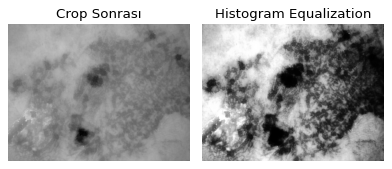

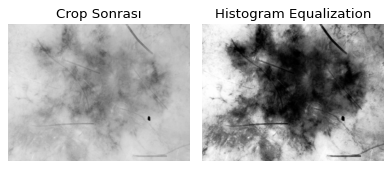

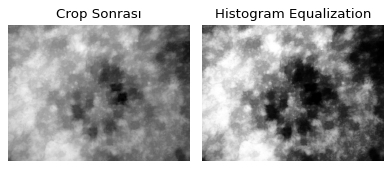

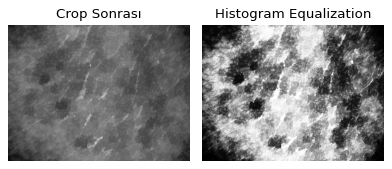

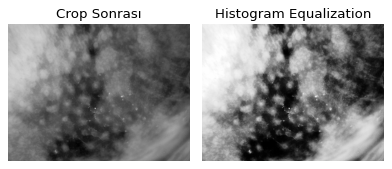

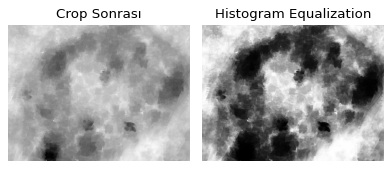

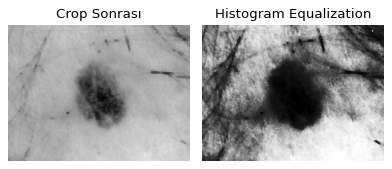

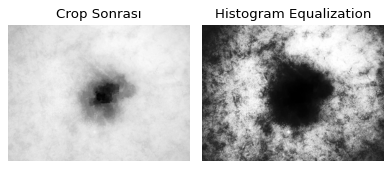

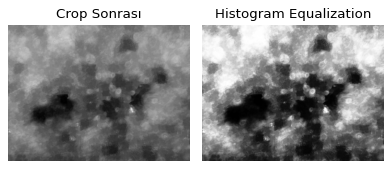

In [71]:
import os
import random
import matplotlib.pyplot as plt
from skimage.io import imread
from IPython.display import Image, display

os.makedirs("figures", exist_ok=True)

k = min(9, len(image_paths))
sample_paths = random.sample(image_paths, k)

for i, p in enumerate(sample_paths):
    rgb = imread(p)
    gray_clean = hair_removal_rgb(rgb)
    cropped = center_crop(gray_clean, crop_ratio=0.1)
    enhanced = contrast_enhancement(cropped)


    plt.figure(figsize=(5, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(cropped, cmap="gray")
    plt.title("Crop Sonrası")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced, cmap="gray")
    plt.title("Histogram Equalization")
    plt.axis("off")

    out_path = f"figures/preprocess_{i}.png"

    plt.tight_layout()
    plt.savefig(
        out_path,
        dpi=80,
        bbox_inches="tight"
    )
    plt.close()

    display(Image(filename=out_path, width=400))



**2.3 Gürültü Azaltma / Blurring**

**2.3.1 Blur yöntemi seçimi: Median Blur**

In [30]:
import cv2
import numpy as np

def denoise_blur(img_gray_float, ksize=5, method="median"):
    """
    img_gray_float: [0,1] aralığında float grayscale
    return: [0,1] aralığında float grayscale
    """
    img_u8 = (np.clip(img_gray_float, 0, 1) * 255).astype(np.uint8)

    if method == "median":
        # ksize tek sayı olmalı (3,5,7,...)
        out_u8 = cv2.medianBlur(img_u8, ksize)
    elif method == "gaussian":
        out_u8 = cv2.GaussianBlur(img_u8, (ksize, ksize), 0)
    else:
        raise ValueError("method 'median' veya 'gaussian' olmalı")

    return out_u8.astype(np.float32) / 255.0


**2.3.2 9 örnek: dönüşüm öncesi/sonrası görseller**

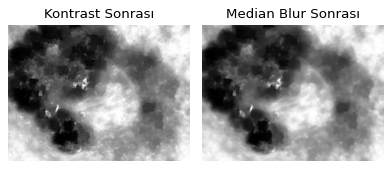

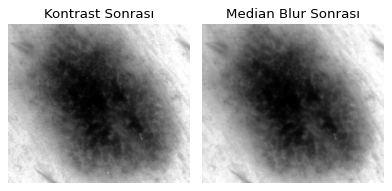

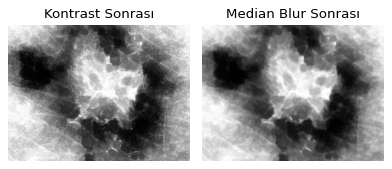

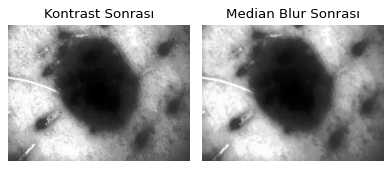

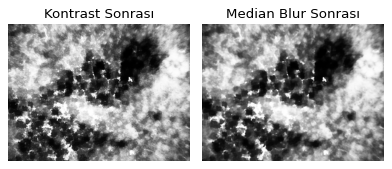

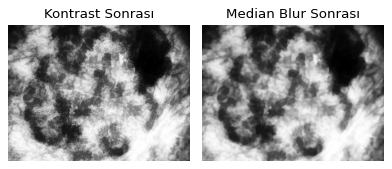

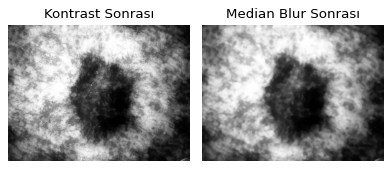

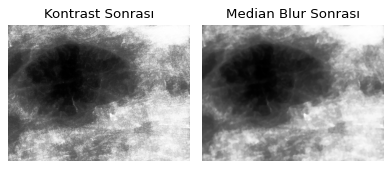

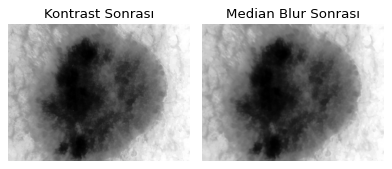

In [32]:
import os
import random
import matplotlib.pyplot as plt
from skimage.io import imread
from IPython.display import Image, display

os.makedirs("figures", exist_ok=True)


k = min(9, len(image_paths))
sample_paths = random.sample(image_paths, k)

for i, p in enumerate(sample_paths):
    rgb = imread(p)

    gray_clean_u8 = hair_removal_rgb(rgb)
    gray_clean = gray_clean_u8.astype("float32") / 255.0

    cropped = center_crop(gray_clean, crop_ratio=0.1)
    enhanced = contrast_enhancement(cropped)
    blurred = denoise_blur(enhanced, ksize=5, method="median")

    plt.figure(figsize=(5, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(enhanced, cmap="gray")
    plt.title("Kontrast Sonrası")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(blurred, cmap="gray")
    plt.title("Median Blur Sonrası")
    plt.axis("off")

    out_path = f"figures/blur_{i}.png"

    plt.tight_layout()
    plt.savefig(
        out_path,
        dpi=80,
        bbox_inches="tight"
    )
    plt.close()


    display(Image(filename=out_path, width=400))


**3 - Thresholding ile Segmentasyon**



**3.0 Yardımcı: pipeline çıktısını üret (blurred görüntü)**

In [33]:
from skimage import exposure

def preprocess_to_blur(img_rgb):
    # 1) Kıl bastırma (uint8 gray)
    gray_u8 = hair_removal_rgb(img_rgb)
    gray = gray_u8.astype(np.float32) / 255.0

    # 2) Crop
    cropped = center_crop(gray, crop_ratio=0.1)

    # 3) Kontrast (Histogram Equalization)
    enhanced = exposure.equalize_hist(cropped).astype(np.float32)

    # 4) Blur (Median)
    blurred = denoise_blur(enhanced, ksize=5, method="median")
    return blurred


**3.1 Threshold değerlerini hesapla (Global + Otsu + Try-all’den 1 yöntem)**

In [34]:
import numpy as np
import pandas as pd
from skimage.filters import threshold_otsu, threshold_yen, try_all_threshold

def compute_thresholds(img_gray_float):
    """
    img_gray_float: [0,1] float
    """
    # Global threshold: sabit bir değer seçiyoruz (genelde 0.5 başlangıçtır)
    # İstersen bunu histogramına bakıp 0.45/0.55 gibi ayarlayabiliriz.
    t_global = 0.5

    # Otsu: otomatik eşik
    t_otsu = float(threshold_otsu(img_gray_float))

    # try_all_threshold içinden bir yöntem seçiyoruz: örnek olarak Yen (otomatik)
    # (try_all_threshold görselleştirme içindir; burada seçtiğimiz yöntemin eşik değerini raporluyoruz)
    t_yen = float(threshold_yen(img_gray_float))

    return {
        "Global": t_global,
        "Otsu": t_otsu,
        "Yen (try_all seçimi)": t_yen
    }


**3.1 Çıktı: 9 örnek için eşik değerlerini print + tablo**

In [35]:
import random
from skimage.io import imread

sample_paths = random.sample(image_paths, 9)

rows = []
for p in sample_paths:
    rgb = imread(p)
    blurred = preprocess_to_blur(rgb)
    ths = compute_thresholds(blurred)

    rows.append({
        "image_path": p,
        "Global_T": ths["Global"],
        "Otsu_T": ths["Otsu"],
        "Yen_T": ths["Yen (try_all seçimi)"]
    })

thr_df = pd.DataFrame(rows)

print("Eşik değerleri (9 örnek):")
print(thr_df[["Global_T", "Otsu_T", "Yen_T"]])

thr_df


Eşik değerleri (9 örnek):
   Global_T    Otsu_T     Yen_T
0       0.5  0.468857  0.165365
1       0.5  0.492203  0.204274
2       0.5  0.488312  0.363802
3       0.5  0.484421  0.091437
4       0.5  0.492203  0.153692
5       0.5  0.472748  0.165365
6       0.5  0.484421  0.375475
7       0.5  0.480530  0.223729
8       0.5  0.492203  0.177037


,image_path,Global_T,Otsu_T,Yen_T
0,/content/drive/MyDrive/ISIC_data/extracted/Ski...,0.5,0.468857,0.165365
1,/content/drive/MyDrive/ISIC_data/extracted/Ski...,0.5,0.492203,0.204274
2,/content/drive/MyDrive/ISIC_data/extracted/Ski...,0.5,0.488312,0.363802
3,/content/drive/MyDrive/ISIC_data/extracted/Ski...,0.5,0.484421,0.091437
4,/content/drive/MyDrive/ISIC_data/extracted/Ski...,0.5,0.492203,0.153692
5,/content/drive/MyDrive/ISIC_data/extracted/Ski...,0.5,0.472748,0.165365
6,/content/drive/MyDrive/ISIC_data/extracted/Ski...,0.5,0.484421,0.375475
7,/content/drive/MyDrive/ISIC_data/extracted/Ski...,0.5,0.480530,0.223729
8,/content/drive/MyDrive/ISIC_data/extracted/Ski...,0.5,0.492203,0.177037


3.2 Binary maskeleri üret + 9 örnekte karşılaştırmalı görselleştir

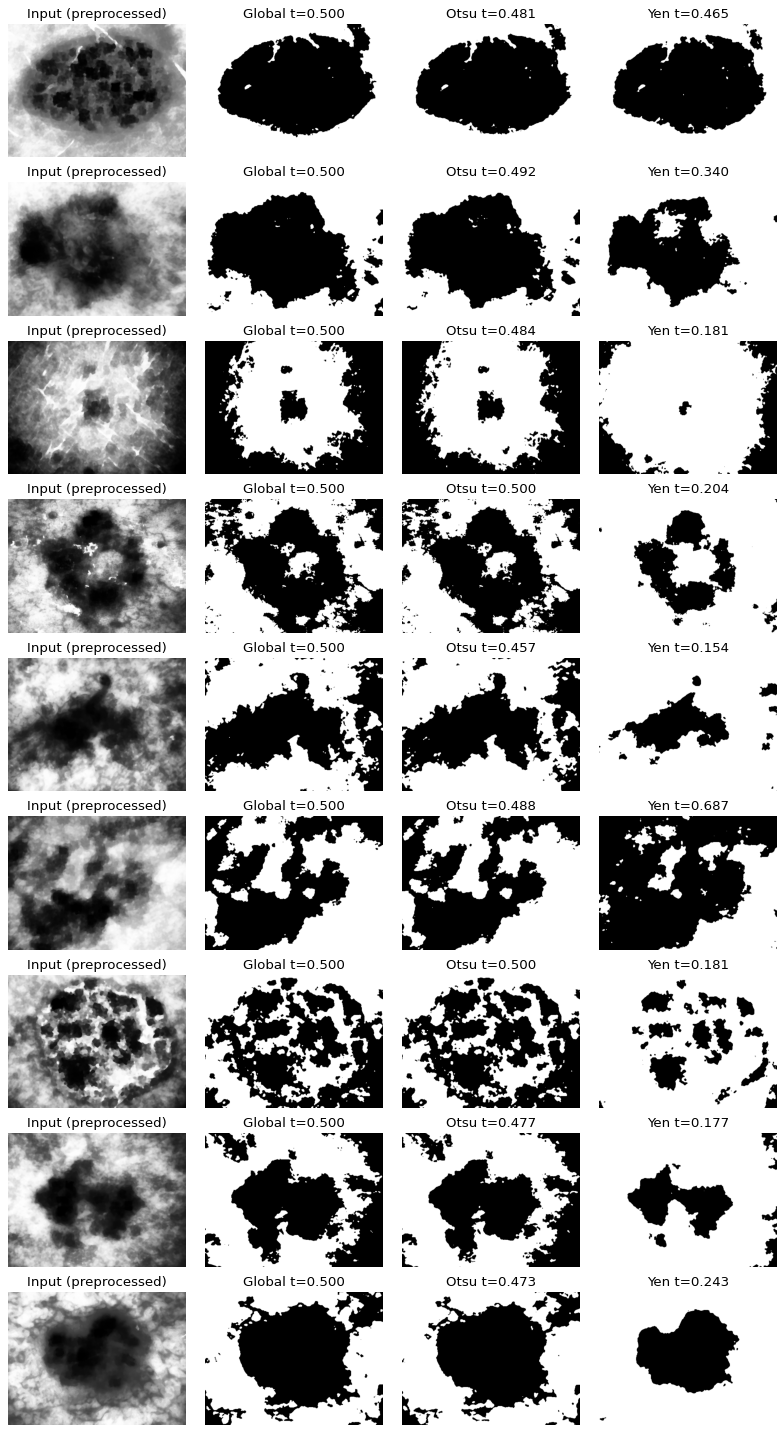

Kaydedildi: figures/threshold_compare_9samples.png
Kaydedildi: figures/threshold_values_9samples.csv
        image_id  t_global   t_otsu    t_yen
ISIC_0025879.jpg       0.5 0.480530 0.464966
ISIC_0028611.jpg       0.5 0.492203 0.340456
ISIC_0025378.jpg       0.5 0.484421 0.180928
ISIC_0010393.jpg       0.5 0.499985 0.204274
ISIC_0031413.jpg       0.5 0.457184 0.153692
ISIC_0026679.jpg       0.5 0.488312 0.686749
ISIC_0029647.jpg       0.5 0.499985 0.180928
ISIC_0025605.jpg       0.5 0.476639 0.177037
ISIC_0026433.jpg       0.5 0.472748 0.243183


In [72]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_otsu, threshold_yen
from IPython.display import Image, display

os.makedirs("figures", exist_ok=True)

# --- 9 örnek seç (güvenli) ---
k = min(9, len(image_paths))
sample_paths = random.sample(image_paths, k)

def preprocess_for_threshold(rgb):
    """
    Senin pipeline: hair removal -> gray(0..1) -> crop -> contrast -> blur
    """
    gray_u8 = hair_removal_rgb(rgb)                 # u8 gray
    gray = gray_u8.astype(np.float32) / 255.0       # 0..1

    cropped = center_crop(gray, crop_ratio=0.1)
    enhanced = contrast_enhancement(cropped)
    blurred = denoise_blur(enhanced, ksize=5, method="median")
    return blurred


GLOBAL_T = 0.5

plt.figure(figsize=(10, 18))

thr_table = []

for i, p in enumerate(sample_paths):
    rgb = imread(p)
    img = preprocess_for_threshold(rgb)  # 0..1, blur sonrası

    # Threshold değerleri
    t_otsu = float(threshold_otsu(img))
    t_yen  = float(threshold_yen(img))
    t_glob = float(GLOBAL_T)

    # Binary maskeler
    m_global = (img > t_glob).astype(np.uint8)
    m_otsu   = (img > t_otsu).astype(np.uint8)
    m_yen    = (img > t_yen).astype(np.uint8)

    thr_table.append([os.path.basename(p), t_glob, t_otsu, t_yen])

    # 1) Input
    ax = plt.subplot(9, 4, 4*i + 1)
    ax.imshow(img, cmap="gray", vmin=0, vmax=1)
    ax.set_title("Input (preprocessed)")
    ax.axis("off")

    # 2) Global
    ax = plt.subplot(9, 4, 4*i + 2)
    ax.imshow(m_global, cmap="gray")
    ax.set_title(f"Global t={t_glob:.3f}")
    ax.axis("off")

    # 3) Otsu
    ax = plt.subplot(9, 4, 4*i + 3)
    ax.imshow(m_otsu, cmap="gray")
    ax.set_title(f"Otsu t={t_otsu:.3f}")
    ax.axis("off")

    # 4) Yen
    ax = plt.subplot(9, 4, 4*i + 4)
    ax.imshow(m_yen, cmap="gray")
    ax.set_title(f"Yen t={t_yen:.3f}")
    ax.axis("off")

plt.tight_layout()

out_path = "figures/threshold_compare_9samples.png"
plt.savefig(out_path, dpi=80, bbox_inches="tight")
plt.close()

display(Image(filename=out_path, width=900))

# Threshold değerlerini yazdır (rapor için)
import pandas as pd
thr_df = pd.DataFrame(thr_table, columns=["image_id", "t_global", "t_otsu", "t_yen"])
thr_df.to_csv("figures/threshold_values_9samples.csv", index=False)

print("Kaydedildi:", out_path)
print("Kaydedildi:", "figures/threshold_values_9samples.csv")
print(thr_df.head(9).to_string(index=False))




**try_all_threshold’i 1 örnekte gösterme**

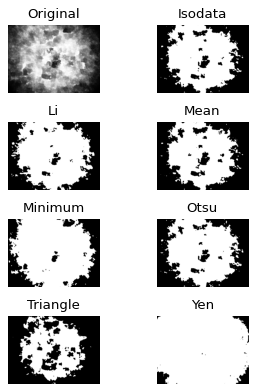

Kaydedildi: figures/try_all_threshold_example.png


In [78]:
os.makedirs("figures", exist_ok=True)

# 1 örnek seç
p = image_paths[0]
rgb = imread(p)

# Senin pipeline: hair → gray → crop → contrast → blur
gray_clean_u8 = hair_removal_rgb(rgb)
gray_clean = gray_clean_u8.astype("float32") / 255.0
cropped = center_crop(gray_clean, crop_ratio=0.1)
enhanced = contrast_enhancement(cropped)
blurred = denoise_blur(enhanced, ksize=5, method="median")

# try_all_threshold (küçük figsize)
fig, ax = try_all_threshold(
    blurred,
    figsize=(6, 5),
    verbose=False
)

out_path = "figures/try_all_threshold_example.png"
plt.tight_layout()
plt.savefig(out_path, dpi=80, bbox_inches="tight")
plt.close()

display(Image(filename=out_path, width=600))
print("Kaydedildi:", out_path)


**4 - Post-Processing**

**4.1 Morfolojik Operatörler**

In [50]:
def morph_postprocess_safe(mask_bin, ksize_close=5):
    """
    Güvenli post-processing:
    - SADECE closing
    - küçük kernel
    - ROI tamamen silinirse geri al
    """
    m = (mask_bin * 255).astype(np.uint8)

    kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (ksize_close, ksize_close)
    )

    closed = cv2.morphologyEx(m, cv2.MORPH_CLOSE, kernel)

    # Güvenlik: eğer ROI yok olduysa orijinale dön
    if np.sum(closed) == 0:
        closed = m.copy()

    return (closed > 0).astype(np.uint8)


**9 örnek: giriş maske + morfoloji sonrası**

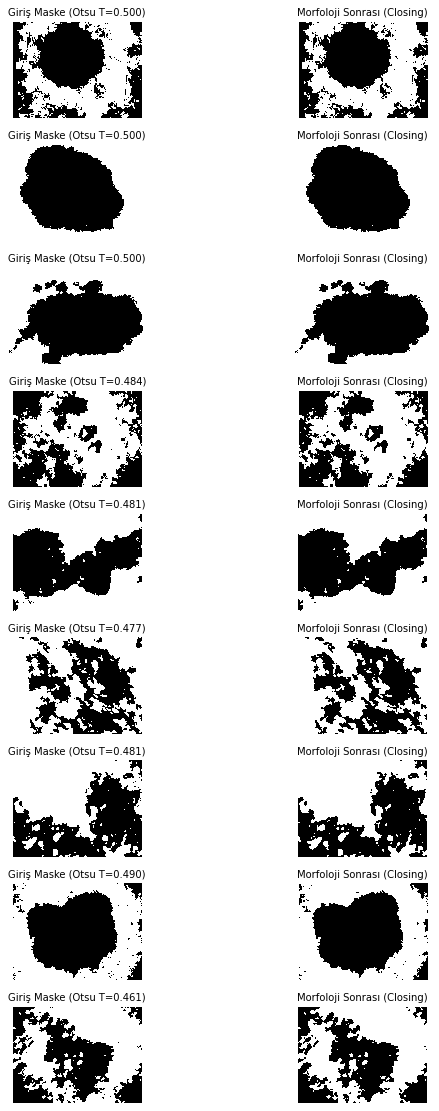

Kaydedildi: figures/otsu_morphology_comparison.png


In [81]:
os.makedirs("figures", exist_ok=True)

k = min(9, len(sample_paths))
paths = sample_paths[:k]

plt.figure(figsize=(9, 14))

for i, p in enumerate(paths):
    rgb = imread(p)

    _, t, mask_otsu = otsu_mask_from_rgb(rgb)

    # Morfoloji sonrası
    mask_morph = morph_postprocess_safe(mask_otsu, ksize_close=5)

    # --- Giriş maske ---
    plt.subplot(9, 2, 2*i + 1)
    plt.imshow(mask_otsu, cmap="gray", interpolation="nearest")
    plt.title(f"Giriş Maske (Otsu T={t:.3f})", fontsize=9)
    plt.axis("off")

    # --- Morfoloji sonrası ---
    plt.subplot(9, 2, 2*i + 2)
    plt.imshow(mask_morph, cmap="gray", interpolation="nearest")
    plt.title("Morfoloji Sonrası (Closing)", fontsize=9)
    plt.axis("off")

plt.tight_layout()

out_path = "figures/otsu_morphology_comparison.png"
plt.savefig(
    out_path,
    dpi=80,
    bbox_inches="tight"
)
plt.close()

display(Image(filename=out_path, width=900))

print("Kaydedildi:", out_path)


**4.2 Connected Component Labeling (CCL)**

**4.2.0 — Yardımcı fonksiyonlar**

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from skimage.measure import regionprops, label # regionprops eklendi

def connected_components(mask_bin):
    """
    mask_bin: 0/1 uint8
    return: num_labels (bg dahil), labels, fg_count (bg hariç)
    """
    num_labels, labels = cv2.connectedComponents(mask_bin.astype(np.uint8))
    return num_labels, labels, (num_labels - 1)

def labels_to_color(labels):
    """
    labels: 0..K (0 bg)
    Renkli label görüntüsü üretir.
    """
    if labels.max() == 0:
        return np.zeros((*labels.shape, 3), dtype=np.uint8)

    lab_u8 = (labels.astype(np.float32) / labels.max() * 255).astype(np.uint8)
    colored = cv2.applyColorMap(lab_u8, cv2.COLORMAP_JET)
    colored = cv2.cvtColor(colored, cv2.COLOR_BGR2RGB)
    return colored

def keep_largest_component(mask_bin):
    """
    1 görüntü = 1 ROI hedefi için: en büyük alanlı bileşeni tut.
    """
    num_labels, labels = cv2.connectedComponents(mask_bin.astype(np.uint8))
    if num_labels <= 2:  # bg + 1 fg
        return mask_bin

    areas = []
    for lab in range(1, num_labels):
        areas.append((lab, int(np.sum(labels == lab))))

    largest_lab = max(areas, key=lambda x: x[1])[0]
    out = (labels == largest_lab).astype(np.uint8)
    return out

def pick_single_roi(mask_bin, min_area):
    """
    Verilen maskeden en büyük bağlı bileşeni seçer ve minimum alan şartını kontrol eder.
    mask_bin: 0/1 uint8 binary maske
    min_area: Minimum kabul edilebilir ROI alanı
    return: Eğer geçerli bir ROI bulunursa 0/1 uint8 maskesi, aksi takdirde None
    """
    largest_mask = keep_largest_component(mask_bin)

    if np.sum(largest_mask) == 0:
        return None

    # largest_mask'in tek bir ROI içerdiğini varsayarak (keep_largest_component tarafından sağlanır)
    # regionprops ile alanını kontrol et
    lbl = label(largest_mask, connectivity=2) # 8-bağlantı için connectivity=2
    props = regionprops(lbl)

    if not props: # Eğer maskede gerçekten bir ROI yoksa (sadece 0'lardan oluşuyorsa)
        return None

    # largest_mask'te sadece bir bileşen olduğu için ilkini al
    area = props[0].area

    if area >= min_area:
        return largest_mask
    else:
        return None


**4.2.1 — 9 örnek: bileşen sayısını çizdir + renkli label plot**

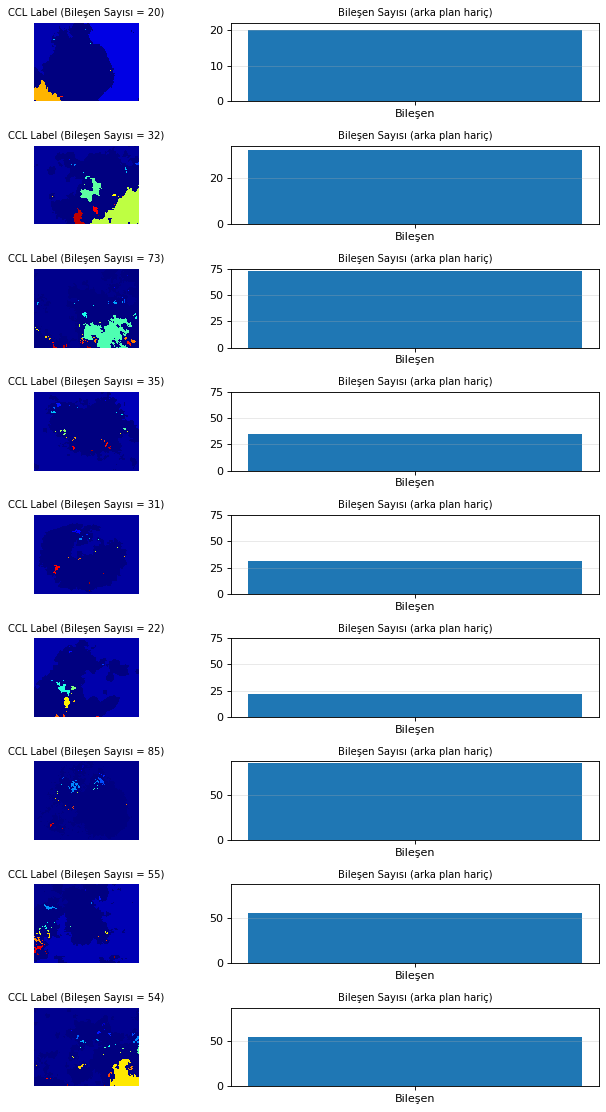

Kaydedildi: figures/ccl_9samples_labels_and_counts.png
9 örnek bileşen sayıları: [20, 32, 73, 35, 31, 22, 85, 55, 54]


In [82]:
os.makedirs("figures", exist_ok=True)


k = min(9, len(image_paths))
sample_paths = random.sample(image_paths, k)

component_counts_plot = []


plt.figure(figsize=(9, 14))

for i, p in enumerate(sample_paths):
    rgb = imread(p)

    # 4.1: morfoloji sonrası maske
    _, _, mask_otsu = otsu_mask_from_rgb(rgb)
    mask_morph = morph_postprocess_safe(mask_otsu, ksize_close=5)

    # 4.2: Connected Component Labeling
    _, labels_before, fg_before = connected_components(mask_morph)
    fg_before = int(fg_before)
    component_counts_plot.append(fg_before)

    # Renkli label görüntüsü
    colored = labels_to_color(labels_before)

    # Sol: renkli CCL label
    plt.subplot(9, 2, 2*i + 1)
    plt.imshow(colored, interpolation="nearest")
    plt.title(f"CCL Label (Bileşen Sayısı = {fg_before})", fontsize=9)
    plt.axis("off")

    # Sağ: bileşen sayısını ÇİZDİR (bar plot)
    plt.subplot(9, 2, 2*i + 2)
    plt.bar(["Bileşen"], [fg_before])
    plt.ylim(0, max(component_counts_plot) + 2)
    plt.title("Bileşen Sayısı (arka plan hariç)", fontsize=9)
    plt.grid(axis="y", alpha=0.3)

plt.tight_layout()

out_path = "figures/ccl_9samples_labels_and_counts.png"
plt.savefig(out_path, dpi=80, bbox_inches="tight")
plt.close()


display(Image(filename=out_path, width=900))
print("Kaydedildi:", out_path)
print("9 örnek bileşen sayıları:", component_counts_plot)



**5 - Öznitelik (Feature) Çıkarımı**

**5.1 First-Order (İstatistiksel) Özellikler**

In [60]:
import numpy as np
from scipy.stats import skew, kurtosis

def first_order_features(gray_img, roi_mask):
    pixels = gray_img[roi_mask == 1]

    feats = {}
    feats["mean"] = float(np.mean(pixels))
    feats["std"] = float(np.std(pixels))
    feats["variance"] = float(np.var(pixels))
    feats["min"] = float(np.min(pixels))
    feats["max"] = float(np.max(pixels))
    feats["median"] = float(np.median(pixels))
    feats["skewness"] = float(skew(pixels))
    feats["kurtosis"] = float(kurtosis(pixels))

    # Entropy
    hist, _ = np.histogram(pixels, bins=256, density=True)
    hist = hist[hist > 0]
    feats["entropy"] = float(-np.sum(hist * np.log2(hist)))

    # Energy
    feats["energy"] = float(np.sum(pixels ** 2))

    return feats


**5.2 2D Shape (Şekil) Özellikleri**

In [61]:
from skimage.measure import regionprops, label

def shape_features(roi_mask):
    lbl = label(roi_mask)
    props = regionprops(lbl)[0]   # 1 ROI varsayımı

    feats = {}
    feats["area"] = props.area
    feats["perimeter"] = props.perimeter
    feats["eccentricity"] = props.eccentricity
    feats["solidity"] = props.solidity
    feats["extent"] = props.extent

    feats["major_axis_length"] = props.major_axis_length
    feats["minor_axis_length"] = props.minor_axis_length
    feats["aspect_ratio"] = props.major_axis_length / props.minor_axis_length

    feats["convex_area"] = props.convex_area
    feats["equivalent_diameter"] = props.equivalent_diameter

    # Circularity
    feats["circularity"] = (4 * np.pi * props.area) / (props.perimeter ** 2)

    # Bounding box
    minr, minc, maxr, maxc = props.bbox
    feats["bbox_width"] = maxc - minc
    feats["bbox_height"] = maxr - minr

    return feats


**5.3 GLCM (Second-Order Texture) Özellikleri**

In [62]:
from skimage.feature import graycomatrix, graycoprops

def glcm_features(gray_img, roi_mask,
                  distances=[1, 2],
                  angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                  levels=16):

    # ROI dışını maskele
    masked = gray_img.copy()
    masked[roi_mask == 0] = 0

    # Quantization
    img_q = np.floor(masked * (levels - 1)).astype(np.uint8)

    glcm = graycomatrix(
        img_q,
        distances=distances,
        angles=angles,
        levels=levels,
        symmetric=True,
        normed=True
    )

    feats = {}
    for prop in ["contrast", "dissimilarity", "homogeneity",
                 "energy", "correlation", "ASM"]:
        feats[f"glcm_{prop}"] = float(np.mean(graycoprops(glcm, prop)))

    return feats


**5.4 Feature Tablosu (CSV)**

In [66]:
import numpy as np
import pandas as pd
import cv2

from tqdm import tqdm
from skimage.io import imread
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import label, regionprops


MIN_AREA = 500
GLCM_LEVELS = 8
GLCM_DISTANCES = [1]
GLCM_ANGLES = [0, np.pi/2]
GLCM_PATCH_SIZE = 128


def safe_imread(path):
    try:
        x = imread(path)
        return x if x is not None else None
    except:
        return None


def crop_to_roi_patch(gray_img, roi_mask, patch_size=GLCM_PATCH_SIZE):
    # ROI boşsa güvenli çık
    if roi_mask is None or np.sum(roi_mask) == 0:
        return None, None

    props = regionprops(label(roi_mask))
    if len(props) == 0:
        return None, None

    cy, cx = map(int, props[0].centroid)
    half = patch_size // 2

    y1 = max(cy - half, 0)
    y2 = min(cy + half, gray_img.shape[0])
    x1 = max(cx - half, 0)
    x2 = min(cx + half, gray_img.shape[1])

    g = gray_img[y1:y2, x1:x2]
    m = roi_mask[y1:y2, x1:x2].astype(np.uint8)

    # patch boyutu tutmazsa padding
    if g.shape[0] != patch_size or g.shape[1] != patch_size:
        g_pad = np.zeros((patch_size, patch_size), dtype=g.dtype)
        m_pad = np.zeros((patch_size, patch_size), dtype=m.dtype)
        g_pad[:g.shape[0], :g.shape[1]] = g
        m_pad[:m.shape[0], :m.shape[1]] = m
        g, m = g_pad, m_pad

    return g, m


def glcm_feats(gray_img, roi_mask):
    g, m = crop_to_roi_patch(gray_img, roi_mask, patch_size=GLCM_PATCH_SIZE)
    if g is None:
        return {f"glcm_{p}": np.nan for p in ["contrast","dissimilarity","homogeneity","energy","correlation","ASM"]}

    masked = g.copy()
    masked[m == 0] = 0

    # gray [0,1] değilse normalize
    if masked.max() > 1.0:
        masked = masked / 255.0

    img_q = np.floor(np.clip(masked, 0, 1) * (GLCM_LEVELS - 1)).astype(np.uint8)

    glcm = graycomatrix(
        img_q,
        distances=GLCM_DISTANCES,
        angles=GLCM_ANGLES,
        levels=GLCM_LEVELS,
        symmetric=True,
        normed=True
    )

    out = {}
    for p in ["contrast","dissimilarity","homogeneity","energy","correlation","ASM"]:
        out[f"glcm_{p}"] = float(np.mean(graycoprops(glcm, p)))
    return out


rows = []
skipped = 0
no_roi = 0

print("✅ GLCM Parametreleri:",
      "levels=", GLCM_LEVELS,
      "distances=", GLCM_DISTANCES,
      "angles=", GLCM_ANGLES,
      "patch=", GLCM_PATCH_SIZE)

for p in tqdm(image_paths, desc="Feature extraction", unit="image"):
    rgb = safe_imread(p)
    if rgb is None:
        skipped += 1
        continue

    image_id = p.split("/")[-1]

    gray = preprocess_to_blur(rgb)

    _, _, mask_otsu = otsu_mask_from_rgb(rgb)
    mask_morph = morph_postprocess_safe(mask_otsu, ksize_close=5)
    mask_final = pick_single_roi(mask_morph, min_area=MIN_AREA)

    if mask_final is None or np.sum(mask_final) == 0:
        no_roi += 1
        continue

    row = {"image_id": image_id, "class": "unknown"}
    row.update(first_order_features(gray, mask_final))
    row.update(shape_features(mask_final))
    row.update(glcm_feats(gray, mask_final))
    rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("lesion_features.csv", index=False)

print("✅ Bitti.")
print("Toplam görüntü (liste):", len(image_paths))
print("İşlenen satır (ROI) sayısı:", df.shape[0])
print("Feature sütun sayısı:", df.shape[1])
print("Atlanan (okunamayan) dosya:", skipped)
print("ROI bulunamayan:", no_roi)
print("CSV:", "lesion_features.csv")

print(df.head(5).to_string(index=False))


✅ GLCM Parametreleri: levels= 8 distances= [1] angles= [0, 1.5707963267948966] patch= 128


Feature extraction:   4%|▍         | 95/2357 [05:15<07:24,  5.08image/s]/usr/local/lib/python3.12/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
Feature extraction: 100%|██████████| 2357/2357 [33:27<00:00,  1.17image/s]


✅ Bitti.
Toplam görüntü (liste): 2357
İşlenen satır (ROI) sayısı: 2356
Feature sütun sayısı: 31
Atlanan (okunamayan) dosya: 1
ROI bulunamayan: 0
CSV: lesion_features.csv
        image_id   class     mean      std  variance      min      max   median  skewness  kurtosis      entropy        energy     area   perimeter  eccentricity  solidity   extent  major_axis_length  minor_axis_length  aspect_ratio  convex_area  equivalent_diameter  circularity  bbox_width  bbox_height  glcm_contrast  glcm_dissimilarity  glcm_homogeneity  glcm_energy  glcm_correlation  glcm_ASM
ISIC_0024654.jpg unknown 0.729276 0.153285  0.023496 0.298039 0.996078 0.721569 -0.028888 -1.158377 -1381.855370  52455.167969  94456.0 3897.176116      0.487451  0.797878 0.652681         392.453882         342.671265      1.145278     118384.0           346.792610     0.078152         402          360       0.261811            0.136750          0.943409     0.503663          0.967845  0.253677
ISIC_0024646.jpg unknown 0.73470